1\. **2D minimization of a six-hump camelback function**

$$f(x,y) = \left(4-2.1x^2+\frac{x^4}{3} \right) x^2 +xy + (4y^2 -4)y^2$$

has multiple global and local minima.

- Find the global minima of this function
- How many global minima are there, and what is the function value at those points?
- What happens for an initial guess of $(x, y) = (0, 0)$?

Hints:

* Variables can be restricted to $-2 < x < 2$ and $-1 < y < 1$.
* Use `numpy.meshgrid()` and `pylab.imshow()` to find visually the regions.
* Use `scipy.optimize.minimize()`, optionally trying its optional arguments.

In [6]:
import numpy as np
from pylab import meshgrid,cm,imshow,contour,clabel,colorbar,axis,title,show
import matplotlib.pyplot as plt
from scipy import optimize


Task 1: Find Global Minima



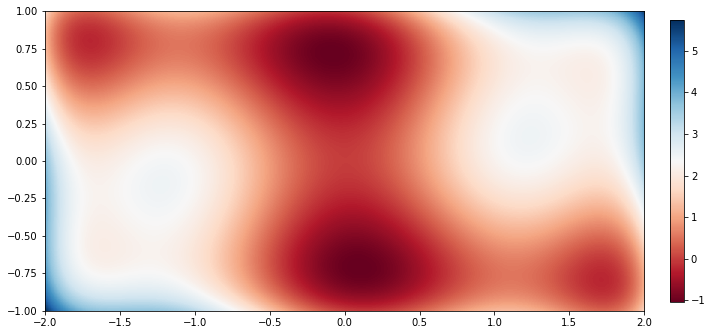

In [7]:
def z_func(x):
 return (((4-2.1*x[0]**2+x[0]**4/3)*x[0]**2)+x[0]*x[1]+(4*x[1]**2-4)*x[1]**2)

print("Task 1: Find Global Minima\n")
x = np.arange(-2.0,2.0,0.01)
y = np.arange(-1.0,1.0,0.01)
X,Y = meshgrid(x, y) # grid of point
Z = z_func([X, Y])

fig1 = plt.figure(figsize=(10,10))
ax1 = fig1.add_subplot(1,1,1) 
im=ax1.imshow(Z,cmap=cm.RdBu, extent=[-2.0,2.0,-1.0,1.0], origin='lower') # drawing the function


plt.colorbar(im,fraction=0.022, pad=0.04)
fig1.tight_layout()

In [8]:
print('''Apparently two global minima are present in approximately (0,-0.76) and (0,0.76). Other local minima are present
To find them numerically I can use the optimize.minimize()\n\n''')


solution_1 = optimize.minimize(z_func,(0,-0.75),bounds=[(-0.25,0.25),(-1,-0.5)], tol=10**-8)
print("First global minimum:\n\n",solution_1,'\n')

solution_2 = optimize.minimize(z_func,(0,0.75),bounds=[(-0.25,0.25),(0.5,1)],tol=10**-8)
print("Second global minimum:\n\n",solution_2,'\n')

print("The algorithm has converged nicely imposing a certain tolerance threshold\nTo conclude the two global minima are:\n",solution_1.x," and ",solution_2.x)
print("There are two global minima as one can see from the graph and the numerical results")
print("The function value at this points is", solution_1.fun)
print("For an initial guess (x,y)=(0,0) we find a local minimum:\n")
solution_guess = optimize.minimize(z_func,(0,0))
print(solution_guess)

Apparently two global minima are present in (0,-0.76) and (0,0.76) and other local minima
To find them numerically I can use the optimize.minimize()


First global minimum:

       fun: -1.0316284534897975
 hess_inv: <2x2 LbfgsInvHessProduct with dtype=float64>
      jac: array([-1.06581410e-06,  2.22044604e-08])
  message: 'CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH'
     nfev: 21
      nit: 5
     njev: 7
   status: 0
  success: True
        x: array([ 0.08984187, -0.7126564 ]) 

Second global minimum:

       fun: -1.031628453489807
 hess_inv: <2x2 LbfgsInvHessProduct with dtype=float64>
      jac: array([ 1.08801856e-06, -2.22044604e-08])
  message: 'CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH'
     nfev: 21
      nit: 5
     njev: 7
   status: 0
  success: True
        x: array([-0.08984188,  0.71265639]) 

The algorithm has converged nicely imposing a certain tolerance threshold
To conclude the two global minima are:
 [ 0.08984187 -0.7126564 ]  and  [-0.08984188  0.71265

2\. **Curve fitting of temperature in Alaska** 

The temperature extremes in Alaska for each month, starting in January, are given by (in degrees Celcius):

max:  `17,  19,  21,  28,  33,  38, 37,  37,  31,  23,  19,  18`

min: `-62, -59, -56, -46, -32, -18, -9, -13, -25, -46, -52, -58`

* Plot these temperatures.
* Find a suitable a function that can describe min and max temperatures. 
* Fit this function to the data with `scipy.optimize.curve_fit()`.
* Plot the result. Is the fit reasonable? If not, why?
* Is the time offset for min and max temperatures the same within the fit accuracy?

Plotting the temperature



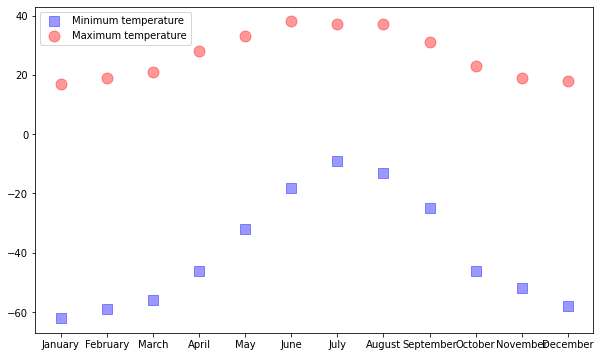

In [9]:
print("Plotting the temperature\n")
gridsize = (3, 2)
fig = plt.figure(figsize=(10, 6))
ax1 = fig.add_subplot(111)

maxi=np.array([17,  19,  21,  28,  33,  38, 37,  37,  31,  23,  19,  18])
mini=np.array([-62, -59, -56, -46, -32, -18, -9, -13, -25, -46, -52, -58])
months = ['January', 'February', 'March', 'April', 'May', 'June', 'July',
          'August', 'September', 'October', 'November', 'December']

ax1.scatter(months, mini, s=120, c='b', marker="s", label='Minimum temperature',alpha=0.4)
ax1.scatter(months, maxi, s=120, c='r', marker="o", label='Maximum temperature',alpha=0.4)
plt.legend(loc='upper left');
plt.show()


Find a suitable a function that can describe min and max temperatures.


I'm using shifted gaussians to fit the data

Parameters:
 [52.64929349  6.16452592  1.9759005  61.32094078]


Covariance Matrix:
 [[ 1.96936653e+00 -8.73506252e-04  2.27190734e-02  1.05131046e+00]
 [-8.73506252e-04  2.22850200e-03 -4.92555887e-05 -1.09102073e-03]
 [ 2.27190734e-02 -4.92555887e-05  5.77330191e-03  7.06524737e-02]
 [ 1.05131046e+00 -1.09102073e-03  7.06524737e-02  1.41331618e+00]]
Const 	=	 52.65 	+-	 1.40
month 	=	 6.16 	+-	 0.05
Sigma 	=	 1.98 	+-	 0.08
Shift 	=	 61.32 	+-	 1.19

Parameters:
 [ 23.09208674   5.73581633   2.29443582 -15.77931912]


Covariance Matrix:
 [[ 1.32861382e+00 -1.60400227e-03  1.01470728e-01  1.08333049e+00]
 [-1.60400227e-03  6.31511611e-03 -2.12203848e-04 -1.91621217e-03]
 [ 1.01470728e-01 -2.12203848e-04  2.75427269e-02  1.70924130e-01]
 [ 1.08333049e+00 -1.91621217e-03  1.70924130e-01  1.38424466e+00]]
Const 	=	 23.09 	+-	 1.15
month 	=	 5.74 	+-	 0.08
Sigma 	=	 2.29 	

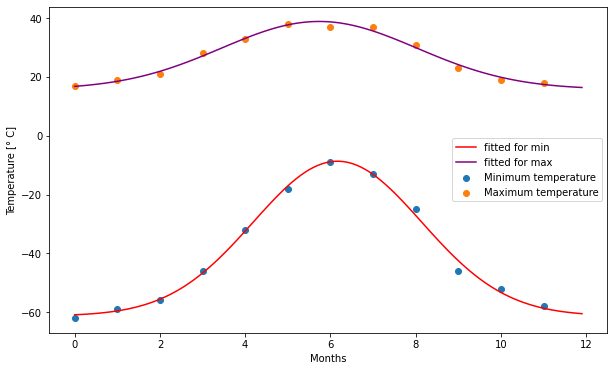

In [10]:
print("Find a suitable a function that can describe min and max temperatures.\n\n\nI'm using shifted gaussians to fit the data")

def gaus_shifted(x, const, mu, sigma,S):
    return const * np.exp(-0.5*(x-mu)**2/sigma**2)-S 



popt, pcov = optimize.curve_fit(gaus_shifted, np.arange(np.size(mini)), mini, p0=[60,7,2,60], full_output=False)
print("\nParameters:\n", popt)
print("\n\nCovariance Matrix:\n", pcov)
print("Const \t=\t %.2f \t+-\t %.2f" % (popt[0], np.sqrt(pcov[0,0])))
print("month \t=\t %.2f \t+-\t %.2f" % (popt[1], np.sqrt(pcov[1,1])))
print("Sigma \t=\t %.2f \t+-\t %.2f" % (popt[2], np.sqrt(pcov[2,2])))
print("Shift \t=\t %.2f \t+-\t %.2f" % (popt[3], np.sqrt(pcov[3,3])))




popt_max, pcov_max = optimize.curve_fit(gaus_shifted, np.arange(np.size(maxi)), maxi, p0=[20,7,3,19], full_output=False)
print("\nParameters:\n", popt_max)
print("\n\nCovariance Matrix:\n", pcov_max)
print("Const \t=\t %.2f \t+-\t %.2f" % (popt_max[0], np.sqrt(pcov_max[0,0])))
print("month \t=\t %.2f \t+-\t %.2f" % (popt_max[1], np.sqrt(pcov_max[1,1])))
print("Sigma \t=\t %.2f \t+-\t %.2f" % (popt_max[2], np.sqrt(pcov_max[2,2])))
print("Shift \t=\t %.2f +-\t %.2f" % (popt_max[3], np.sqrt(pcov_max[3,3])))

plt.figure(figsize=(10, 6))
plt.scatter(np.arange(np.size(mini)), mini, label='Minimum temperature')
plt.scatter(np.arange(np.size(mini)), maxi, label='Maximum temperature')
plt.plot(np.arange(start=0,stop=np.size(mini),step=0.1), gaus_shifted(np.arange(start=0,stop=np.size(mini),step=0.1), popt[0], popt[1],popt[2],popt[3]), label='fitted for min',c='red')
plt.plot(np.arange(start=0,stop=np.size(mini),step=0.1), gaus_shifted(np.arange(start=0,stop=np.size(mini),step=0.1), popt_max[0], popt_max[1],popt_max[2],popt_max[3]), label='fitted for max',c='purple')
plt.xlabel("Months")
plt.ylabel("Temperature [\N{DEGREE SIGN} C]")
plt.legend(loc='best')
plt.show()

In [26]:
print('Is the fit reasonable? The fit seems to work properly in both cases. One can prove this looking at the correlation coefficient\n ')
ssr = np.sum((mini - gaus_shifted(np.arange(np.size(mini)),popt[0],popt[1],popt[2],popt[3]))**2)
tss = np.sum((np.mean(mini) - mini)**2)
rsq = 1 - ssr / tss
print("For minima we have: RSQ=",rsq)

ssr_max = np.sum((maxi - gaus_shifted(np.arange(np.size(mini)),popt_max[0],popt_max[1],popt_max[2],popt_max[3]))**2)
tss_max = np.sum((np.mean(maxi) - maxi)**2)
rsq_max = 1 - ssr_max / tss_max
print("For maxima we have: RSQ=",rsq_max)


print('\n\nThe time offset is the same for max and min within fit accuracy?')
print('Z-test between the means of the gaussian to evaluate if the maximum of both the distributions occurs at the same time within fit accuracy:', (popt[1]-popt_max[1])/np.sqrt(pcov[1,1]+pcov_max[1,1]))
print('The means are not compatible')


Is the fit reasonable? The fit seems to work properly in both cases. One can prove this looking at the correlation coefficient
 
For minima we have: RSQ= 0.9946041936397156
For maxima we have: RSQ= 0.9858796078359655


The time offset is the same for max and min within fit accuracy?
Z-test between the means of the gaussian to evaluate if the maximum of both the distributions occurs at the same time within fit accuracy: 4.638123156380021
The means are not compatible


3\. **Fit the residues**

Read the `data/residuals_261.pkl` file. If you haven't it already, download it from here:

```bash
wget https://www.dropbox.com/s/3uqleyc3wyz52tr/residuals_261.pkl -P data/
```

The feature name "residual" contains the residuals (defined as $y_i - \hat{y}_i$) of a linear regression as a function of the independent variable "distances".

- Considering only the "residual" feature, create an histogram with the appropriate binning and display it.
- Set the appropriate Poisson uncertainty for each bin (thus, for each bin, $\sigma_i = \sqrt{n_i}$, where $n_i$ is the number of entries in each bin)
- By looking at the distribution of the residuals, define an appropriate function and fit it to the histogram of the residuals
- Perform a goodness-of-fit test. Is the p-value of the fit satisfactory?

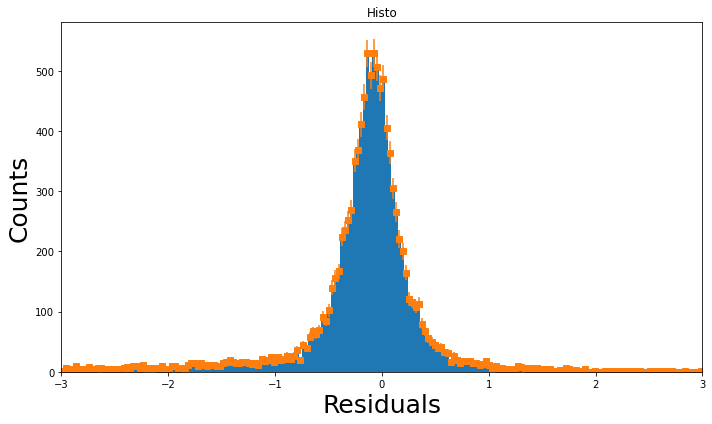

In [65]:
import pickle
import pandas as pd
filename = "data/residuals_261.pkl"
infile = open(filename, 'rb') 
new_dict = pickle.load(infile) 
infile.close()

data=dict(new_dict.item())
df=pd.DataFrame(data)
#limited range to exclude outliers from the fit
df[abs(df.residuals)<3]

xl=-3
xu=3

fig, ax = plt.subplots(figsize=(10, 6)) # create the figure and the axes

yvalues, bins, _ = plt.hist(df['residuals'], bins=200, range=(xl, xu), cumulative=False) 
binwidth=bins[1]-bins[0]
bins=bins[:len(bins)-1]

ax.set_title('Histo')
ax.set_xlabel('Residuals',fontsize=25)
ax.set_ylabel('Counts', fontsize=25)
ax.set_xlim(-3,3)
ax.errorbar(bins+binwidth/2, yvalues, yerr=np.sqrt(yvalues), marker='s', linestyle='None')
fig.tight_layout()


In [66]:
#gaus_definition
def gaus(x, const, mu, sigma):
    return const * np.exp(-0.5*(x-mu)**2/sigma**2)



Performing the fit:

Parameters:
 [ 4.85267079e+02 -8.69473800e-02  2.25076158e-01]


Covariance Matrix:
 [[ 3.18006498e+01  1.43815730e-10 -9.83294930e-03]
 [ 1.43815730e-10  9.12121896e-06 -2.33971332e-14]
 [-9.83294930e-03 -2.33971332e-14  9.12121866e-06]]
Const 	=	 485.27 	+-	 5.64
Mean 	=	 -0.087 	+-	 0.003
Sigma 	=	 0.225 	+-	 0.003


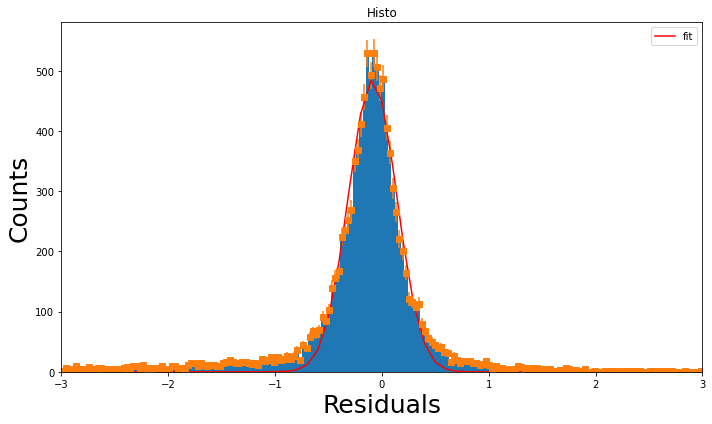

In [69]:
print("Performing the fit:")
popt_r, pcov_r = optimize.curve_fit(gaus, bins+binwidth/2, yvalues, p0=[500,0,1], full_output=False)
print("\nParameters:\n", popt_r)
print("\n\nCovariance Matrix:\n", pcov_r)
print("Const \t=\t %.2f \t+-\t %.2f" % (popt_r[0], np.sqrt(pcov_r[0,0])))
print("Mean \t=\t %.3f \t+-\t %.3f" % (popt_r[1], np.sqrt(pcov_r[1,1])))
print("Sigma \t=\t %.3f \t+-\t %.3f" % (popt_r[2], np.sqrt(pcov_r[2,2])))




fig, ax = plt.subplots(figsize=(10, 6)) # create the figure and the axes

yvalues, bins, _ = plt.hist(df['residuals'], bins=200, range=(xl, xu), cumulative=False) 
binwidth=bins[1]-bins[0]
bins=bins[:len(bins)-1]

ax.set_title('Histo')
ax.set_xlabel('Residuals',fontsize=25)
ax.set_ylabel('Counts', fontsize=25)
ax.set_xlim(-3,3)
ax.errorbar(bins+binwidth/2, yvalues, yerr=np.sqrt(yvalues), marker='s', linestyle='None')
ax.plot(np.arange(start=xl,stop=xu,step=0.1), gaus(np.arange(start=xl,stop=xu,step=0.1), popt_r[0], popt_r[1],popt_r[2]), label='fit',c='red')
ax.legend(loc='best')
fig.tight_layout()

In [68]:
from scipy import stats
print("I am creating a dataframe with the counts of histo and the value of the function in the middle point in order not to consider the bins without any count (division by zero)")
dataf=pd.DataFrame()
dataf['left bins']=np.linspace(xl,xu,200)
dataf['fit']=gaus(np.linspace(xl,xu,200), popt_r[0], popt_r[1],popt_r[2])
dataf['experimental']=yvalues


#I'm consering non zero values in order not to divide by zero
dataf = dataf[dataf.experimental>0.9]
fit=gaus(np.linspace(xl,xu,200), popt_r[0], popt_r[1],popt_r[2])

ndof = len(dataf.experimental) - 1
chi2 = np.sum(((dataf.experimental- dataf.fit)**2) /(dataf.experimental))
print("chi2 =", chi2)


pvalue = 1. - stats.chi2.cdf(chi2, ndof)
print("p-value =", pvalue) 
print("Fit unsatisfactory")


I am creating a dataframe with the counts of histo and the value of the function in the middle point in order not to consider the bins without any count (division by zero)
chi2 = 1558.1995776840902
p-value = 0.0
Fit unsatisfactory


4\. **Temperatures in Munich**

Get the following data file:

```bash
https://www.dropbox.com/s/7gy9yjl00ymxb8h/munich_temperatures_average_with_bad_data.txt
```

which gives the temperature in Munich every day for several years.


Fit the following function to the data:

$$f(t) = a \cos(2\pi t + b)+c$$

where $t$ is the time in years.

- Make a plot of the data and the best-fit model in the range 2008 to 2012.

   - What are the best-fit values of the parameters?

   - What is the overall average temperature in Munich, and what are the typical daily average values predicted by the model for the coldest and hottest time of year?

   - What is the meaning of the $b$ parameter, and what physical sense does it have?


- Now fit the data with the function $g(x)$, which has 1 more parameter than $f(x)$.
$$g(x) = a \cos(2\pi b t + c)+d$$
   - What are the RSS for $f(x)$ and $g(x)$?
   - Use the Fisher F-test to determine whether the additional parameter is motivated.

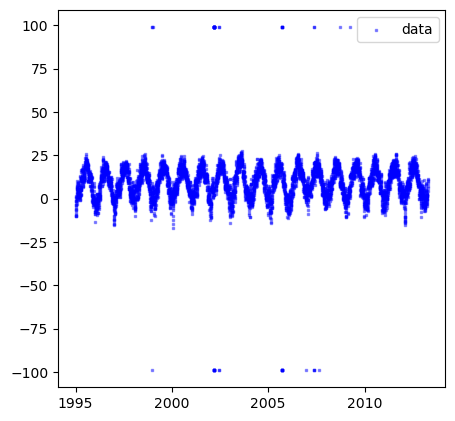

It's clear some non physical data have been taken. So firstly it is important to remove the unphysical points
I define a mask that eliminates all the points with nominal temperature +-99


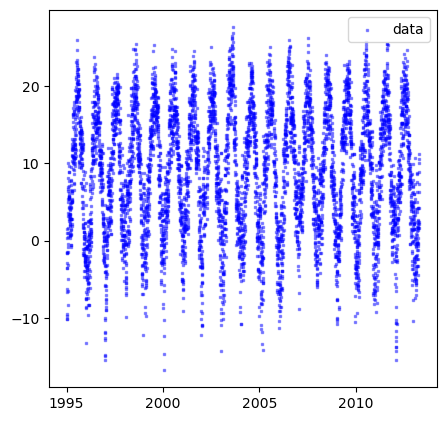

Now the fit can be done with the f(x) function
Fitting the function to the data
parameters:
 [9.95518358 2.88862795 9.04084545]
covariance matrix:
 [[ 4.33827111e-03  2.06703346e-06  4.67784574e-05]
 [ 2.06703346e-06  4.42924432e-05 -2.58453854e-06]
 [ 4.67784574e-05 -2.58453854e-06  2.18211979e-03]]
A = 9.96 +- 0.07
b = 2.89 +- 0.01
c = 9.04 +- 0.05


In [23]:
#!wget https://www.dropbox.com/s/7gy9yjl00ymxb8h/munich_temperatures_average_with_bad_data.txt
import numpy as np
from pylab import meshgrid,cm,imshow,contour,clabel,colorbar,axis,title,show
import matplotlib.pyplot as plt
from matplotlib.ticker import MultipleLocator



filename = "data/munich_temperatures_average_with_bad_data.txt"
data=np.loadtxt(filename)
t=data.T[0]
y=data.T[1]

#plotting
fig = plt.figure(figsize=(5,5))
fig.set_dpi(100)
#1*1 grid
ax1 = fig.add_subplot(111)
ax1.scatter(t, y, s=2, c='b', marker="s", label='data',alpha=0.4)
ax1.legend(loc='best')
ax1.xaxis.set_major_locator(MultipleLocator(5))

plt.show()
#nota 

print("It's clear some non physical data have been taken. So firstly it is important to remove the unphysical points")
print("I define a mask that eliminates all the points with nominal temperature +-99")
b = np.ma.masked_outside(y, -90, 90).mask
t = t[~b]
y = y[~b]




#
#plotting
fig = plt.figure(figsize=(5,5))
fig.set_dpi(100)
#1*1 grid
ax1 = fig.add_subplot(111)
ax1.scatter(t, y, s=2, c='b', marker="s", label='data',alpha=0.4)
ax1.legend(loc='best')
ax1.xaxis.set_major_locator(MultipleLocator(5))

plt.show()




print("Now the fit can be done with the f(x) function")
print("Fitting the function to the data")
def func(x, A, b,c):
    return A*np.cos(2*np.pi * x + b)+c

fit_par, fit_cov = optimize.curve_fit(func, t, y, p0=[9,3,12], full_output=False)
print("parameters:\n", fit_par)
print("covariance matrix:\n", fit_cov)
print("A = %.2f +- %.2f" % (fit_par[0], np.sqrt(fit_cov[0,0])))
print("b = %.2f +- %.2f" % (fit_par[1], np.sqrt(fit_cov[1,1])))
print("c = %.2f +- %.2f" % (fit_par[2], np.sqrt(fit_cov[2,2])))


1)Make a plot of the data and the best-fit model in the range 2008 to 2012.

Result: Function fitted to all the dataset. Showing only the range specified


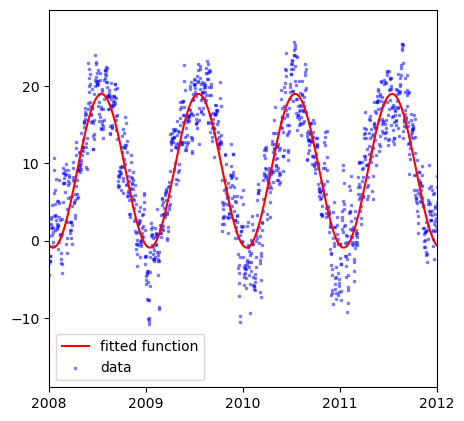

2)What are the best-fit values of the parameters?
Best fit parameters are:
 [9.95518358 2.88862795 9.04084545] 


3)What is the overall average temperature in Munich, and what are the typical daily average values predicted by the model for the coldest and hottest time of year?
The average temperature in Munich is given by the parameter c: 9.04084545218549 


The typical daily average value predicted by the model for the coldest days of the year in Munich is given by -A+c:
 -0.9143381312879892 


The typical daily average value predicted by the model for the hottest days of the year in Munich is given by A+c:
 18.99602903565897 


4)What is the meaning of b parameter, and what physical sense does it have??

It is a shift in the argument of the cosine that lets the model have one more degree of freedom. Without b we would be assuming that at t=0 the temperature is at its maximum (or minimum according to the sign of A).
With b we are taking into account the possibility of having whatever 

In [31]:

print("1)Make a plot of the data and the best-fit model in the range 2008 to 2012.\n\nResult: Function fitted to all the dataset. Showing only the range specified")



#plotting
fig = plt.figure(figsize=(5,5))
fig.set_dpi(100)
#1*1 grid
ax1 = fig.add_subplot(111)
ax1.scatter(t, y, s=2, c='b', marker="s", label='data',alpha=0.4)
ax1.plot(t, func(t, fit_par[0], fit_par[1],fit_par[2]), label='fitted function',color='red')
ax1.legend(loc='best')
ax1.xaxis.set_major_locator(MultipleLocator(1))
ax1.set_xlim([2008,2012])
plt.show()

print("2)What are the best-fit values of the parameters?")
print("Best fit parameters are:\n", fit_par,"\n\n")

print("3)What is the overall average temperature in Munich, and what are the typical daily average values predicted by the model for the coldest and hottest time of year?")
print("The average temperature in Munich is given by the parameter c:",fit_par[2],"\n\n")
print("The typical daily average value predicted by the model for the coldest days of the year in Munich is given by -A+c:\n",-fit_par[0]+fit_par[2],"\n\n")
print("The typical daily average value predicted by the model for the hottest days of the year in Munich is given by A+c:\n",fit_par[0]+fit_par[2],"\n\n")
print('''4)What is the meaning of b parameter, and what physical sense does it have??\n\nIt is a shift in the argument of the cosine that lets the model have one more degree of freedom. Without b we would be assuming that at t=0 the temperature is at its maximum (or minimum according to the sign of A).
With b we are taking into account the possibility of having whatever value of the tempreature between A+c and -A+c
when t=0. It can be seen as a shift in frequencies up to a redefinition b->b/2pi
sin(2pi(x+b/2pi))''')


Now fit the data with the function 𝑔(𝑥), which has 1 more parameter than 𝑓(𝑥)
Fitting the function to the data
parameters:
 [9.95538332 0.99976014 5.90922675 9.03978537]
covariance matrix:
 [[ 4.34387737e-03  4.89690512e-07 -6.16436675e-03  4.84906751e-05]
 [ 4.89690512e-07  4.00403570e-08 -5.04210418e-04  1.78115058e-07]
 [-6.16436675e-03 -5.04210418e-04  6.34934197e+00 -2.24546282e-03]
 [ 4.84906751e-05  1.78115058e-07 -2.24546282e-03  2.18275330e-03]]
A = 9.96 +- 0.07
b = 1.00 +- 0.00
c = 5.91 +- 2.52
d = 9.04 +- 0.05
What are the RSS for 𝑓(𝑥) and 𝑔(𝑥)? Use the Fisher F-test to determine whether the additional parameter is
motivated.


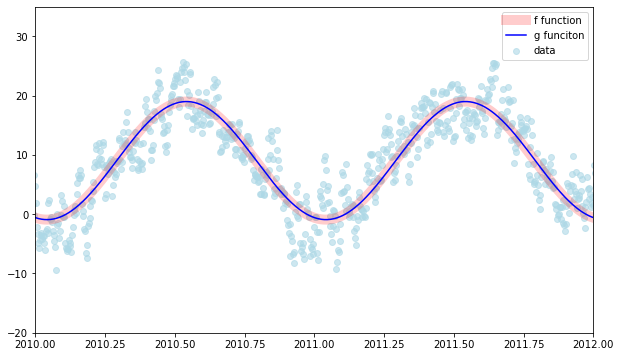

SSR: 95529.062533197 95508.33748280698
Test f vs g:
CL: 0.231 , additional parameter necessary: NO
As one can see from the fitted data the functions are almost the same and the scale parameter is not necessary


In [33]:
from scipy.stats import f
print("Now fit the data with the function 𝑔(𝑥), which has 1 more parameter than 𝑓(𝑥)")

print("Fitting the function to the data")
def g(x, A,b,c,d):
    return A*np.cos(2*np.pi *b* x + c)+d

new_fit_par, new_fit_cov = optimize.curve_fit(g, t, y, p0=[9,1,3,9], full_output=False)
print("parameters:\n", new_fit_par)
print("covariance matrix:\n", new_fit_cov)
print("A = %.2f +- %.2f" % (new_fit_par[0], np.sqrt(new_fit_cov[0,0])))
print("b = %.2f +- %.2f" % (new_fit_par[1], np.sqrt(new_fit_cov[1,1])))
print("c = %.2f +- %.2f" % (new_fit_par[2], np.sqrt(new_fit_cov[2,2])))
print("d = %.2f +- %.2f" % (new_fit_par[3], np.sqrt(new_fit_cov[3,3])))

print('''What are the RSS for 𝑓(𝑥) and 𝑔(𝑥)? Use the Fisher F-test to determine whether the additional parameter is
motivated.''')

# define function for F-test
def Ftest(ssr_1, ssr_2, ndof_1, ndof_2, nbins, verbose=False):
    F = ((ssr_1 - ssr_2)/(ndof_2 - ndof_1)) / (ssr_2/(nbins - ndof_2))
    CL = 1. - f.cdf(F, ndof_2 - ndof_1, nbins - ndof_2)
    if verbose: print("CL: %.3f" % CL, ", additional parameter necessary:", "YES" if CL < 0.10 else "NO")
    return CL

#y values of both functions
y1=func(t, fit_par[0], fit_par[1],fit_par[2])
y2=g(t, new_fit_par[0], new_fit_par[1],new_fit_par[2],new_fit_par[3])
fig, ax = plt.subplots(figsize=(10, 6)) # create the figure and the axes
ax.scatter(x=t, y=y, marker='o', c='lightblue', label="data",alpha=0.6)

ax.plot(t, y1, color='r', lw=10,label="f function",alpha=0.2)
ssr_1 = np.sum((y1 - y)**2)

ax.plot(t, y2, color='b', label="g funciton",alpha=1)
ssr_2 = np.sum((y2 - y)**2)


ax.legend(loc='best')
ax.set_xlim([2010, 2012])
ax.set_ylim([-20, 35])
plt.show()
print("SSR:", ssr_1, ssr_2)

print("Test f vs g:")
cl_1_vs_2 = Ftest(ssr_1, ssr_2, 1, 2, t.size, verbose=True)

print('''As one can see from the fitted data the functions are almost the same and the scale parameter is not necessary''')